In [1]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement


In [2]:
from botorch.test_functions.multi_objective import VehicleSafety

bounds = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0], [3.0, 3.0, 3.0, 3.0, 3.0]])

train_X = torch.rand(10, 5, dtype=torch.float64) * (bounds[1] - bounds[0]) + bounds[0]
function = VehicleSafety()


def evaluate_train_y(x):
    # Evaluate the train_Y values for the given x tensor
    y = function.evaluate_true(x)
    
    y = -y
    
    return y

train_Y = evaluate_train_y(train_X)

print(train_X)
print(train_Y)

tensor([[2.0079, 1.2960, 1.9867, 2.9099, 2.9972],
        [2.3671, 2.9362, 1.5795, 2.3837, 2.2996],
        [2.9439, 2.6132, 2.1530, 2.8715, 2.0748],
        [2.3781, 1.2118, 1.1422, 2.3856, 2.2136],
        [1.9318, 2.2032, 2.4847, 1.6676, 2.2260],
        [1.6900, 2.3058, 1.8592, 2.0550, 1.5907],
        [1.6018, 1.5020, 1.2279, 2.2300, 1.2784],
        [1.7550, 1.4473, 1.7027, 2.6941, 1.9937],
        [2.1243, 2.2961, 1.5096, 1.0511, 2.2084],
        [1.4033, 1.1626, 1.9329, 1.4344, 1.9430]], dtype=torch.float64)
tensor([[-1.6929e+03, -1.1330e+01, -8.2136e-02],
        [-1.6885e+03, -1.0226e+01, -8.1187e-02],
        [-1.6945e+03, -1.0772e+01, -1.1019e-01],
        [-1.6822e+03, -1.0500e+01, -8.9018e-02],
        [-1.6841e+03, -8.7930e+00, -1.5159e-01],
        [-1.6811e+03, -9.5625e+00, -1.2470e-01],
        [-1.6761e+03, -1.0069e+01, -9.7987e-02],
        [-1.6852e+03, -1.0918e+01, -9.9040e-02],
        [-1.6755e+03, -8.3507e+00, -1.2707e-01],
        [-1.6749e+03, -9.0262e+00, -9

In [7]:
#setup gp
model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)


RuntimeError: The size of tensor a (3) must match the size of tensor b (10) at non-singleton dimension 1

In [6]:
output = model(train_X)  # train_x is your input training data

# Compute the negative log likelihood loss
loss = -mll(output, train_Y)

RuntimeError: The size of tensor a (3) must match the size of tensor b (10) at non-singleton dimension 1

In [4]:
print(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)


In [47]:
def perform_optimization_step(model, train_X, train_Y, bounds, num_restarts=10, raw_samples=512):
    
    qNEHVI = qLogNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=torch.tensor([-1864.72022, -11.81993945, -0.2903999384]),
        X_baseline=train_X,
        prune_baseline=True
    )

    # Optimize the acquisition function to find the next point to sample
    new_X, acq_func_value = optimize_acqf(
        acq_function=qNEHVI,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options={"batch_limit": 5, "maxiter": 200},
    )

    print(f"Acquisition function value: {acq_func_value}")
    
    return new_X, acq_func_value


In [48]:
def optimize_vehicle_safety(train_X, train_Y, bounds, num_iterations=100):
    # Setup GP model
    model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_mll(mll)
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")
        new_X, acq_func_value = perform_optimization_step(model, train_X, train_Y, bounds)
        
        print(new_X)

        # Evaluate new Y values
        new_Y = evaluate_train_y(new_X)
        
        # Update training data
        train_X = torch.cat([train_X, new_X], dim=0)
        train_Y = torch.cat([train_Y, new_Y], dim=0)
        
        # Refit model with updated data
        model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))

        mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
        fit_gpytorch_mll(mll)
    
    return train_X, train_Y

In [49]:
train_X, train_Y = optimize_vehicle_safety(train_X, train_Y, bounds)

Iteration 1/100
Acquisition function value: 1.7128730032911035
tensor([[1.2480, 2.3265, 1.7240, 1.3958, 1.3882]])
Iteration 2/100


KeyboardInterrupt: 

In [5]:
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement
from botorch.test_functions.multi_objective import VehicleSafety

bounds = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0], [3.0, 3.0, 3.0, 3.0, 3.0]])

train_X = torch.rand(10, 5, dtype=torch.float64) * (bounds[1] - bounds[0]) + bounds[0]
function = VehicleSafety()


def evaluate_train_y(x):
    # Evaluate the train_Y values for the given x tensor
    y = function.evaluate_true(x)
    
    y = -y
    
    return y

train_Y = evaluate_train_y(train_X)

#setup gp
model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
fit_gpytorch_mll(mll)

def perform_optimization_step(model, train_X, train_Y, bounds, num_restarts=10, raw_samples=512):
    
    qNEHVI = qLogNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=torch.tensor([-1864.72022, -11.81993945, -0.2903999384]),
        X_baseline=train_X,
        prune_baseline=True
    )

    # Optimize the acquisition function to find the next point to sample
    new_X, acq_func_value = optimize_acqf(
        acq_function=qNEHVI,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options={"batch_limit": 5, "maxiter": 200},
    )

    print(f"Acquisition function value: {acq_func_value}")
    
    return new_X, acq_func_value

def optimize_vehicle_safety(train_X, train_Y, bounds, num_iterations=100):
    # Setup GP model
    model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_mll(mll)
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")
        new_X, acq_func_value = perform_optimization_step(model, train_X, train_Y, bounds)
        
        # Evaluate new Y values
        new_Y = evaluate_train_y(new_X)
        
        # Update training data
        train_X = torch.cat([train_X, new_X], dim=0)
        train_Y = torch.cat([train_Y, new_Y], dim=0)
        
        # Refit model with updated data
        model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=3), input_transform=Normalize(d=5))

        mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model) 
        fit_gpytorch_mll(mll)
    
    return train_X, train_Y

train_X, train_Y = optimize_vehicle_safety(train_X, train_Y, bounds)

Iteration 1/100
Acquisition function value: 1.7368759123789639
Iteration 2/100
Acquisition function value: 1.7490233648451534
Iteration 3/100
Acquisition function value: 1.2360714153033125
Iteration 4/100
Acquisition function value: 1.4049013708054963
Iteration 5/100
Acquisition function value: 1.2529193974578599
Iteration 6/100
Acquisition function value: 1.6555962526104642
Iteration 7/100
Acquisition function value: 1.4182278631637004
Iteration 8/100
Acquisition function value: 1.0070570157407497
Iteration 9/100
Acquisition function value: 1.4255023310962516
Iteration 10/100
Acquisition function value: 1.1794356321795894
Iteration 11/100
Acquisition function value: 1.2235719443091702
Iteration 12/100
Acquisition function value: 0.457291746220311
Iteration 13/100
Acquisition function value: 0.20973019404643978
Iteration 14/100
Acquisition function value: -0.1020894218115247
Iteration 15/100
Acquisition function value: -0.21311523439351188
Iteration 16/100
Acquisition function value: -

c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\optim\optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Acquisition function value: -3.2725757490493157
Iteration 73/100


KeyboardInterrupt: 

In [7]:
import torch

# Set random seed for reproducibility
torch.manual_seed(0)

# Synthetic data parameters
n = 100  # number of data points
d = 1  # input dimension
t = 3  # number of tasks (now we have three different tasks)

# Input data
X = torch.rand(n, d)

# Task labels for three different tasks
task_labels = torch.randint(0, t, (n, 1))

# Create three different sinusoidal functions with different shifts
Y1 = torch.sin(X * (2 * torch.pi) + 0.5) + 0.2 * torch.randn(n, 1)  # Task 0
Y2 = torch.sin(X * (2 * torch.pi) + 1.0) + 0.2 * torch.randn(n, 1)  # Task 1
Y3 = torch.sin(X * (2 * torch.pi) + 1.5) + 0.2 * torch.randn(n, 1)  # Task 2

# Combine the data based on the task labels
Y = torch.zeros(n, 1)
Y[task_labels[:, 0] == 0] = Y1[task_labels[:, 0] == 0]
Y[task_labels[:, 0] == 1] = Y2[task_labels[:, 0] == 1]
Y[task_labels[:, 0] == 2] = Y3[task_labels[:, 0] == 2]

# Combine inputs and task labels
X_augmented = torch.cat([X, task_labels], dim=-1)


In [26]:
X_task1 = torch.rand(0, 1)  # 50 observations, 1 input feature

print(X_task1)

tensor([], size=(0, 1))


In [39]:
# Task-specific input data (these can have different lengths)
X_task1 = torch.rand(50, 1)  # 50 observations, 1 input feature
X_task2 = torch.rand(30, 1)  # 30 observations, 1 input feature
X_task3 = torch.rand(1, 1)  # 20 observations, 1 input feature

# Task-specific output data
Y_task1 = torch.sin(X_task1 * 2 * torch.pi)
Y_task2 = torch.cos(X_task2 * 2 * torch.pi)
Y_task3 = torch.sin(X_task3 * 2 * torch.pi) + torch.cos(X_task3 * 2 * torch.pi)

# Combine inputs and outputs
train_X = torch.cat([X_task1, X_task2, X_task3], dim=0)
train_Y = torch.cat([Y_task1, Y_task2, Y_task3], dim=0)

# Create task feature (0 for task 1, 1 for task 2, 2 for task 3)
task_feature_task1 = torch.zeros(X_task1.shape[0], 1)  # Task 1
task_feature_task2 = torch.ones(X_task2.shape[0], 1)   # Task 2
task_feature_task3 = 2 * torch.ones(X_task3.shape[0], 1)  # Task 3

# Combine task features
task_feature = torch.cat([task_feature_task1, task_feature_task2, task_feature_task3], dim=0)

# Augment the input data with the task feature
X_augmented = torch.cat([train_X, task_feature], dim=1)


In [32]:
print(X_augmented.shape)

torch.Size([81, 2])


In [35]:
print(train_Y.shape)

torch.Size([81, 1])


In [40]:
import torch
from botorch.models import MultiTaskGP
from botorch.models import ModelList
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement

# Create a multi-task GP model


model1 = MultiTaskGP(train_X=X_augmented, train_Y=train_Y, task_feature=1, output_tasks=[0])
model2 = MultiTaskGP(train_X=X_augmented, train_Y=train_Y, task_feature=1, output_tasks=[1])
model3 = MultiTaskGP(train_X=X_augmented, train_Y=train_Y, task_feature=1, output_tasks=[2])

modellist = ModelList(model1, model2, model3)


c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\multitask.py:163: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


In [43]:
mll1 = ExactMarginalLogLikelihood(modellist.models[0].likelihood, modellist.models[0])
mll2 = ExactMarginalLogLikelihood(modellist.models[1].likelihood, modellist.models[1])
mll3 = ExactMarginalLogLikelihood(modellist.models[2].likelihood, modellist.models[2])

fit_gpytorch_mll(mll1)
fit_gpytorch_mll(mll2)
fit_gpytorch_mll(mll3)


c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): MultiTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
  )
)

In [24]:
print(model1.train_targets)

tensor([-0.5444, -1.1598,  1.0852,  0.8761, -0.0157, -1.2676, -0.5996,  0.7136,
        -0.8844, -0.7025, -0.4513, -0.4750,  1.0435,  0.4977,  0.3395, -0.7542,
        -1.3346, -0.6886,  1.0023,  0.7072, -1.1079,  1.2363, -0.3710,  0.2668,
         0.0101, -1.0293,  0.5848,  0.6386,  1.2184, -0.4613, -0.2472,  0.1282,
         0.7985,  0.4203,  0.5228,  0.6125,  0.4153,  0.8525, -0.8394, -0.3309,
        -0.8386,  0.2864, -0.5512,  0.6499,  0.6595,  0.5937, -0.7387, -0.4317,
         0.6304, -0.7950, -0.6002,  0.8454, -0.8798, -0.8137,  0.7670,  1.0436,
        -0.8819,  0.9309,  0.6810, -0.0146, -0.7217, -0.0333,  0.1770, -0.5225,
         0.1558, -0.2434, -0.5449, -0.6695, -0.1326,  0.9270,  0.7928,  0.3378,
        -0.4339, -0.1516,  0.2777,  0.2266, -0.7085,  0.6033, -0.7369,  0.5089,
         0.4733,  0.0308, -0.2200,  0.2780, -0.9355, -0.8938, -0.9085, -0.0733,
        -0.5954,  0.9348, -0.3781, -0.3187, -0.5292, -0.8917,  1.0663,  1.2314,
        -0.1537, -1.1142,  0.6828,  0.26

In [38]:
qNEHVI = qLogNoisyExpectedHypervolumeImprovement(
        model=modellist,
        X_baseline=train_X,
        ref_point=[-2.0, -2.0, -2.0],
        prune_baseline=True
    )


c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning: `cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.model.ModelList'>. Setting `cache_root = False`.
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [ ]:
new_X, acq_func_value = optimize_acqf(
        acq_function=qNEHVI,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )

In [37]:
import torch
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated

def calculate_final_hypervolume(train_Y, ref_point):
    # Ensure train_Y is a 2D tensor and convert to float64 type
    if train_Y.dim() == 1:
        train_Y = train_Y.unsqueeze(0)
    
    train_Y = train_Y.to(torch.float64)
    ref_point = ref_point.to(torch.float64)

    # Filter out the non-dominated points
    is_non_dominated_mask = is_non_dominated(train_Y)
    non_dominated_points = train_Y[is_non_dominated_mask]
    
    # Compute the hypervolume
    bd = DominatedPartitioning(ref_point=ref_point, Y=non_dominated_points)
    hypervolume = bd.compute_hypervolume().item()
    
    return hypervolume

# Example usage:
ref_point = torch.tensor([-1864.72022, -11.81993945, -0.2903999384], dtype=torch.float64)


final_hypervolume = calculate_final_hypervolume(train_Y, ref_point)
print(f"Final Hypervolume: {final_hypervolume}")



Final Hypervolume: 245.36722585820436


In [79]:
from __future__ import annotations
import torch
from botorch.optim.stopping import StoppingCriterion




from abc import ABC, abstractmethod

import torch
from torch import Tensor

'''
This is all from: botorch.optim.stopping
Adjusted here for own functionality
'''



class StoppingCriterion(ABC):
    r"""Base class for evaluating optimization convergence.

    Stopping criteria are implemented as a objects rather than a function, so that they
    can keep track of past function values between optimization steps.

    :meta private:
    """

    @abstractmethod
    def evaluate(self, fvals: Tensor) -> bool:
        r"""Evaluate the stopping criterion.

        Args:
            fvals: tensor containing function values for the current iteration. If
                `fvals` contains more than one element, then the stopping criterion is
                evaluated element-wise and True is returned if the stopping criterion is
                true for all elements.

        Returns:
            Stopping indicator (if True, stop the optimziation).
        """
        pass  # pragma: no cover

    def __call__(self, fvals: Tensor) -> bool:
        return self.evaluate(fvals)


class Extended_ExpMAStoppingCriterion(StoppingCriterion):
    r"""Exponential moving average stopping criterion.

    Computes an exponentially weighted moving average over window length `n_window`
    and checks whether the relative decrease in this moving average between steps
    is less than a provided tolerance level. That is, in iteration `i`, it computes

        v[i,j] := fvals[i - n_window + j] * w[j]

    for all `j = 0, ..., n_window`, where `w[j] = exp(-eta * (1 - j / n_window))`.
    Letting `ma[i] := sum_j(v[i,j])`, the criterion evaluates to `True` whenever

        (ma[i-1] - ma[i]) / abs(ma[i-1]) < rel_tol (if minimize=True)
        (ma[i] - ma[i-1]) / abs(ma[i-1]) < rel_tol (if minimize=False)
    """

    def __init__(
        self,
        maxiter: int = 10000,
        minimize: bool = True,
        n_window: int = 10,
        eta: float = 1.0,
        rel_tol: float = 1e-5,
    ) -> None:
        r"""Exponential moving average stopping criterion.

        Args:
            maxiter: Maximum number of iterations.
            minimize: If True, assume minimization.
            n_window: The size of the exponential moving average window.
            eta: The exponential decay factor in the weights.
            rel_tol: Relative tolerance for termination.
        """
        self.maxiter = maxiter
        self.minimize = minimize
        self.n_window = n_window
        self.rel_tol = rel_tol
        self.iter = 0
        weights = torch.exp(torch.linspace(-eta, 0, self.n_window))
        self.weights = weights / weights.sum()
        self._prev_fvals = None
        self.ma_values = []  # List to store moving average values
        self.rel_values = [] # List to store relative decrease values

    def evaluate(self, fvals: Tensor) -> bool:
        r"""Evaluate the stopping criterion.

        Args:
            fvals: tensor containing function values for the current iteration. If
                `fvals` contains more than one element, then the stopping criterion is
                evaluated element-wise and True is returned if the stopping criterion is
                true for all elements.

        TODO: add support for utilizing gradient information

        Returns:
            Stopping indicator (if True, stop the optimziation).
        """
        self.iter += 1
        if self.iter == self.maxiter:
            return True

        if self._prev_fvals is None:
            self._prev_fvals = fvals.unsqueeze(0)
        else:
            self._prev_fvals = torch.cat(
                [self._prev_fvals[-self.n_window :], fvals.unsqueeze(0)]
            )

        if self._prev_fvals.size(0) < self.n_window + 1:
            return False

        weights = self.weights
        weights = weights.to(fvals)
        if self._prev_fvals.ndim > 1:
            weights = weights.unsqueeze(-1)

        # TODO: Update the exp moving average efficiently
        prev_ma = (self._prev_fvals[:-1] * weights).sum(dim=0)
        ma = (self._prev_fvals[1:] * weights).sum(dim=0)

        # Save the current moving average value
        self.ma_values.append(ma.item() if ma.numel() == 1 else ma.tolist())

        # TODO: Handle approx. zero losses (normalize by min/max loss range)
        rel_delta = (prev_ma - ma) / prev_ma.abs()

        # Save the current relative decrease value
        self.rel_values.append(rel_delta.item() if rel_delta.numel() == 1 else rel_delta.tolist())
        print(f"rel_delta: {rel_delta}, rel_tol: {self.rel_tol}")
        if not self.minimize:
            rel_delta = -rel_delta
        print(f"Rel value: {torch.max(rel_delta)}")
        if torch.max(rel_delta) < self.rel_tol:
            print(f"rel_delta: {rel_delta}, max delta: {torch.max(rel_delta)}  rel_tol: {self.rel_tol} returning true here and ending run")
            print(f"ma_values: {self.ma_values}")
            return True

        return False

    

Window size: 20
rel_delta: -0.013810035772621632, rel_tol: 0.001
Rel value: 0.013810035772621632
rel_delta: -0.01152547262609005, rel_tol: 0.001
Rel value: 0.01152547262609005
rel_delta: -0.008325752802193165, rel_tol: 0.001
Rel value: 0.008325752802193165
rel_delta: -0.0076066236943006516, rel_tol: 0.001
Rel value: 0.0076066236943006516
rel_delta: -0.006364855449646711, rel_tol: 0.001
Rel value: 0.006364855449646711
rel_delta: -0.005517218261957169, rel_tol: 0.001
Rel value: 0.005517218261957169
rel_delta: -0.004623154178261757, rel_tol: 0.001
Rel value: 0.004623154178261757
rel_delta: -0.004288459196686745, rel_tol: 0.001
Rel value: 0.004288459196686745
rel_delta: -0.0038183731958270073, rel_tol: 0.001
Rel value: 0.0038183731958270073
rel_delta: -0.0034720737021416426, rel_tol: 0.001
Rel value: 0.0034720737021416426
rel_delta: -0.00262510497123003, rel_tol: 0.001
Rel value: 0.00262510497123003
rel_delta: -0.002178315771743655, rel_tol: 0.001
Rel value: 0.002178315771743655
rel_delta:

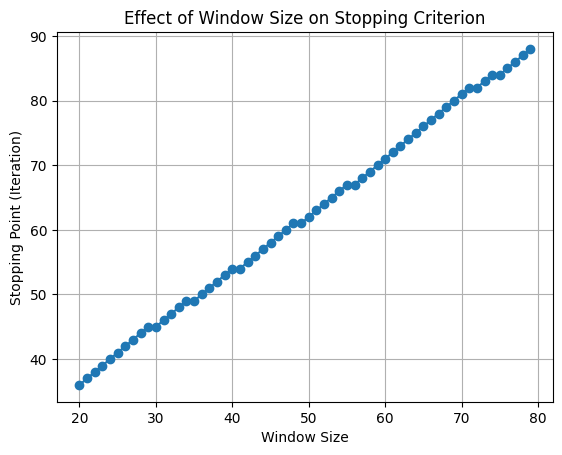

In [82]:
import torch
import matplotlib.pyplot as plt

# Sample hypervolume values for demonstration purposes (replace with your data)
hypervolume_values = [
    153.2380126, 157.5717735, 173.3989851, 195.3442357, 197.5972595, 204.3197897,
    208.8841239, 214.7366362, 215.4019709, 217.9788295, 219.1602191, 224.8609232,
    227.5176778, 229.5122535, 231.1641465, 232.6688746, 235.8291238, 236.8575253,
    237.1220132, 237.9313797, 238.6083927, 238.787785, 240.3095186, 240.7739889,
    240.8975859, 240.8975859, 241.0599763, 241.3689157, 241.3689157, 241.5687262,
    241.5687262, 241.5687262, 241.5687262, 241.5687262, 241.6570348, 241.9340163,
    241.9700686, 242.0008561, 242.0903461, 242.0903461, 242.0908005, 242.2036806,
    242.2945346, 242.3835565, 242.5438438, 242.5706381, 242.6590771, 242.7169338,
    242.8480678, 242.8480678, 242.8818064, 243.0006847, 243.0653833, 243.1156933,
    243.1368538, 243.1368538, 243.2008688, 243.7630455, 243.7630455, 243.7630455,
    243.8099141, 243.8502797, 243.8806319, 243.9029323, 243.9082028, 243.9252032,
    243.9648784, 243.982989, 243.9922082, 244.0001923, 244.0041845, 244.0618873,
    244.0920054, 244.0920054, 244.1164569, 244.1164569, 244.135602, 244.1601484,
    244.5568584, 244.5671745, 244.6400598, 244.6513997, 244.656417, 244.667075,
    244.6802917, 244.8141245, 244.8289649, 244.8289649, 244.8664246, 244.8742845,
    244.8742845, 244.8887114, 244.8949546, 244.9828024, 244.983818, 244.9868443,
    244.9868443, 244.9908164, 244.997568, 245.0050573, 245.0092117, 245.014649,
    245.0527118, 245.4706325, 245.4706325, 245.4935819, 245.4976586, 245.5038482,
    245.5090036, 245.5090036, 245.5245088, 245.5280103, 245.5318157, 245.5392864,
    245.5425655, 245.5532002, 245.5573401, 245.5597284, 245.562946, 245.5663291,
    245.5684111, 245.5773104, 245.6487442, 245.6509552, 245.664969, 245.7373759,
    245.7397132, 245.7458284, 245.7463177, 245.7496551, 245.7549506, 245.7727337,
    245.7736703, 245.7779504, 245.8037376, 245.8218275, 245.8420724, 245.8420724,
    245.8462589, 245.8488313, 245.8522904, 245.8589074, 245.8607105, 245.8638254,
    245.8665143, 245.8681477, 245.8773884, 245.8985887, 245.9024689, 245.9107067,
    245.9119297
]

# Define window sizes to evaluate
window_sizes = list(range(20, 80, 1))

# Function to evaluate the stopping criterion for different window sizes
def evaluate_stopping_criterion(hypervolume_values, window_sizes, rel_tol=0.001):
    stopping_points = []

    for n_window in window_sizes:
        print(f"Window size: {n_window}")
        sc_hypervolume = Extended_ExpMAStoppingCriterion(
            minimize=False,
            n_window=n_window,
            eta=1,
            rel_tol=rel_tol
        )

        for num_iteration in range(len(hypervolume_values) - 1):
            fvals = torch.tensor(hypervolume_values[num_iteration+1])
            if sc_hypervolume.evaluate(fvals):
                stopping_points.append(num_iteration + 1)
                break
        else:
            stopping_points.append(len(hypervolume_values))

    return stopping_points

# Evaluate the stopping criterion for different window sizes
stopping_points = evaluate_stopping_criterion(hypervolume_values, window_sizes)

# Plot the results
plt.plot(window_sizes, stopping_points, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Stopping Point (Iteration)')
plt.title('Effect of Window Size on Stopping Criterion')
plt.grid(True)
plt.show()

